In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re



In [2]:
with open('ActiCap64_LM.lay') as f:
    content = f.readlines()

content = [x.strip() for x in content]
electrodes_pos = np.asarray([re.split('\t', line.replace(' ', '')) for line in content])

In [3]:
electr_coord = pd.DataFrame(np.array([electrodes_pos[:, -1],
                                              electrodes_pos[:, 1].astype(float),
                                              electrodes_pos[:, 2].astype(float)]).T)


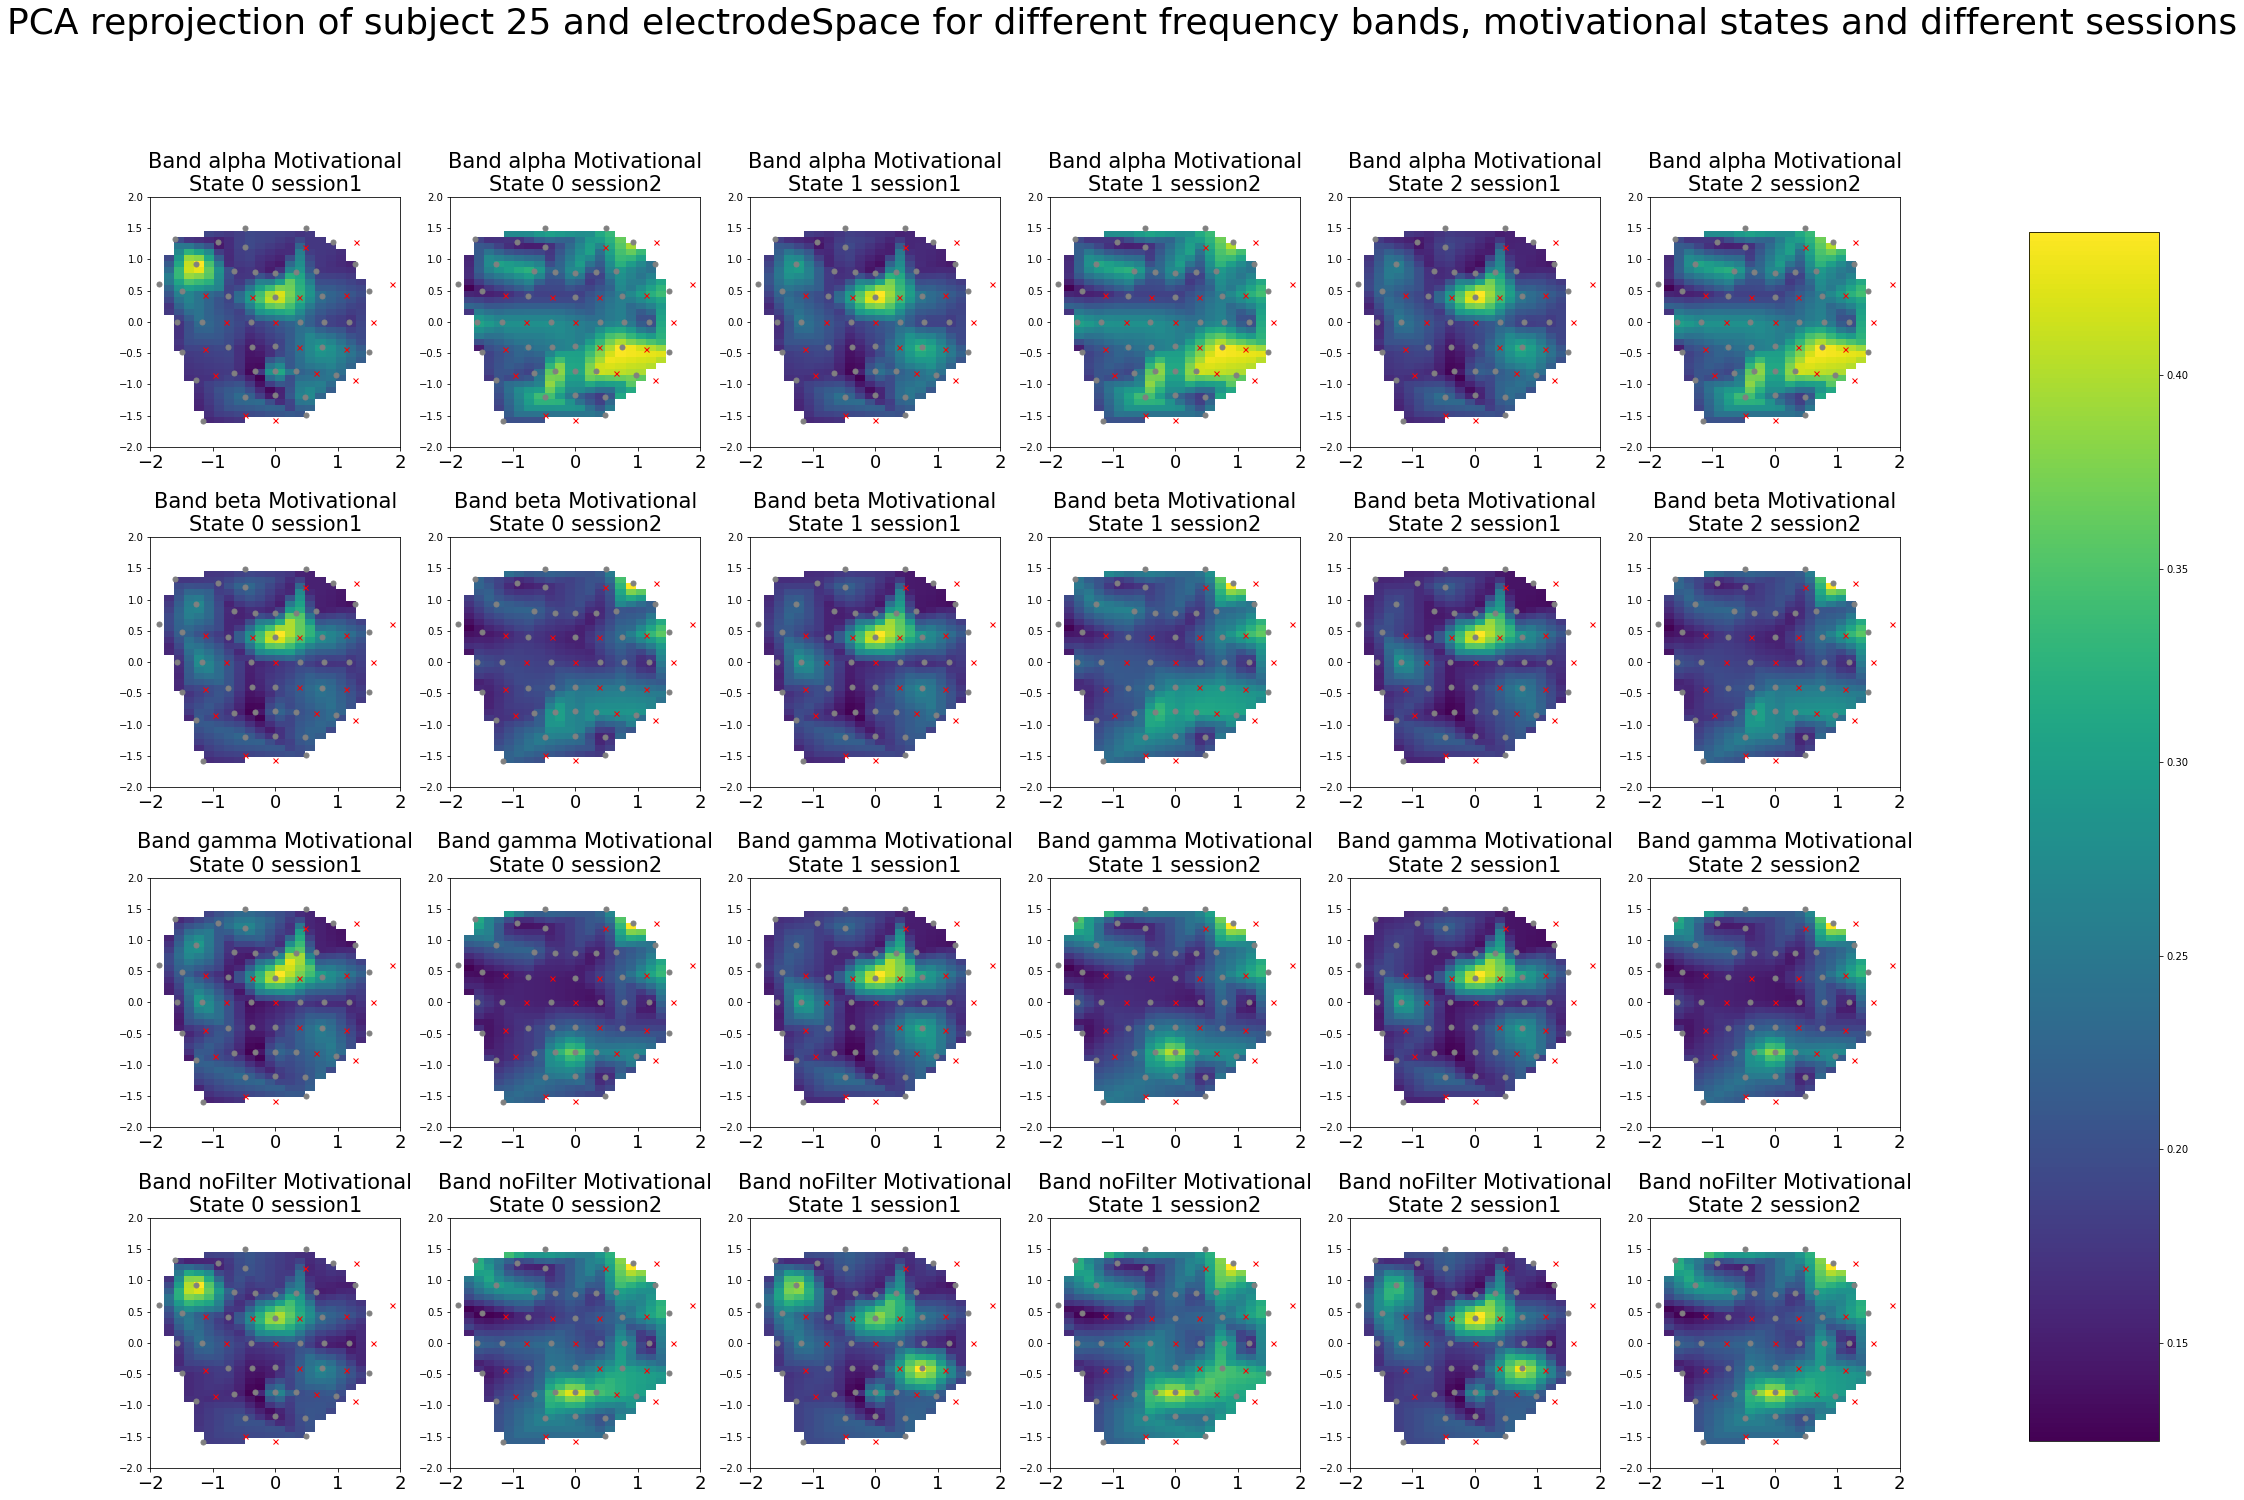

In [26]:
from scipy.interpolate import griddata
fmt_grph = 'png'
subjects=list(range(25,36)) 
bands=[-1,0,1,2] 
sessions=list(range(1,3))
spaces=['electrodeSpace']#,'fontSpace']
band_dic={-1: 'noFilter', 0:'alpha',1:'beta',2:'gamma'} 

for subj in subjects:
    subj_dir="results/intensities/subject_" + str(subj) +'/'
    silent_chan = np.load(subj_dir+'/silent-channels-'+str(subj)+'.npy')
    electr_coord['is_silent'] = silent_chan
    electr_coord.columns = ['electrode_name', 'x', 'y', 'is_silent']
    for space in spaces:
        fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(36, 24))
        plt.rcParams['xtick.labelsize']=18
        for i_band in range(-1,3):
            for j in range(3):
                for ses in range(2):
                    
                    mean=np.load(subj_dir+space+'/'+band_dic[i_band]+'/session'+str(ses+1)+'/reprojected_means_m'+str(j)+'.npy')
                    
                    mean_df=pd.DataFrame(np.concatenate((np.array(electr_coord['electrode_name'])[~silent_chan].reshape(-1,1), mean.reshape(-1,1)),axis=1))
                    mean_df.columns = ['electrode_name', 'mean']
                    
                    plot_table=pd.merge(mean_df.assign(str_name=mean_df.electrode_name.astype(str)),
                                 electr_coord.assign(str_name=electr_coord.electrode_name.astype(str)),
                                 how='inner', on='electrode_name')[['electrode_name', 'is_silent', 'x', 'y',
                                                              'mean']]
                    
                    x = np.array(plot_table.x).astype(float)
                    xs = np.array(electr_coord[electr_coord.is_silent].x).astype(float)
                    y = np.array(plot_table.y).astype(float)
                    ys = np.array(electr_coord[electr_coord.is_silent].y).astype(float)
                    z = np.array(plot_table['mean']).astype(float)
                    
                    grid_x, grid_y = np.mgrid[-8:8:100j, -9:10:200j]
                    
                    points = np.array([x, y]).T
                    silent_points = np.array([xs, ys]).T
                    values = z

                    # plt.colorbar(im, ax=ax[i, j])interpolate
                    zi =griddata(points, values, (grid_x, grid_y), method='linear')

                
                    im=axes[i_band][2*j+ses].imshow(zi.T, extent=(-8.1, 8.1, -9.1, 10.1), origin='lower')
                    axes[i_band][2*j+ses].plot(points[:, 0], points[:, 1], 'o', ms=5, c='grey')
                    axes[i_band][2*j+ses].plot(silent_points[:, 0], silent_points[:, 1], 'x', ms=5, c='red')
                    axes[i_band][2*j+ses].set_xlim([-2, 2])
                    axes[i_band][2*j+ses].set_ylim([-2, 2])
                    #plt.colorbar(im,ax=axes[i_band][2*j+ses])
                    
                    axes[i_band][2*j+ses].set_title('Band '+band_dic[i_band]+' Motivational\nState '+str(j)+' session'+str(ses+1),fontsize=21)
                    
    fig.suptitle('PCA reprojection of subject '+str(subj)+ ' and '+space+' for different frequency bands, motivational states and different sessions',fontsize=36)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #fig.tight_layout(pad=0.75)               
    plt.savefig(subj_dir+space+'/pca_reprojection.png', format=fmt_grph)  
                    
